# Config

In [1]:
# Reload all src modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

In [7]:
import os
import sys
import json
import cProfile
import pandas as pd
import geopandas as geopd
import numpy as np
import multiprocessing as mp
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import descartes
import datetime
import networkx as nx
import src.utils.geometry as geo
import src.utils.places_to_cells as places_to_cells
import src.utils.make_config as make_config
import src.data.shp_extract as shp_extract
import src.data.cells_results as cells_results
import src.data.interactions as interactions
import src.visualization.grid_viz as grid_viz
import src.visualization.helpers as helpers_viz
import src.visualization.networks as net_viz
from dotenv import load_dotenv
load_dotenv()

pd.reset_option("display.max_rows")

In [8]:
data_dir_path = os.environ['DATA_DIR']
tweets_files_format = 'tweets_{}_{}_{}.json.gz'
places_files_format = 'places_{}_{}_{}.json.gz'
ssh_domain = os.environ['IFISC_DOMAIN']
ssh_username = os.environ['IFISC_USERNAME']
fig_dir = os.path.join('..', 'reports', 'figures')
project_data_dir = os.path.join('..', 'data')
external_data_dir = os.path.join(project_data_dir, 'external')
interim_data_dir = os.path.join(project_data_dir, 'interim')
processed_data_dir = os.path.join(project_data_dir, 'processed')
cell_data_path_format = os.path.join(
    processed_data_dir, '{0}', '{0}_cc={1}_r={2}_cell_size={3}m.{4}')
latlon_proj = 'epsg:4326'
user_level_label = '{}-speaking users'
with open(os.path.join(external_data_dir, 'countries.json')) as f:
    countries_study_data = json.load(f)

# Load data

In [15]:
cc = 'ES'
region = 'Catalonia'
# region = None
cell_size = 10000

area_dict = make_config.area_dict(countries_study_data, cc, region=region)
xy_proj = area_dict['xy_proj']
area_name = area_dict['readable']
local_langs = area_dict['local_langs']
min_poly_area = area_dict.get('min_poly_area')
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj,
                             min_area=min_poly_area)
_, cells_in_area_df, _, _ = geo.create_grid(shape_df, cell_size, 
                                            xy_proj=xy_proj, intersect=True)

user_interactions_path = cell_data_path_format.format(
    'user_interactions', cc, area_name, '', 'csv')
raw_user_interactions = pd.read_csv(user_interactions_path,
                                index_col=['uid', 'to_uid'], header=0)
user_cell_ratio_path = cell_data_path_format.format(
    'user_cell_ratio', cc, area_name, cell_size, 'csv')
user_cell_ratio = pd.read_csv(user_cell_ratio_path,
                              index_col=['uid', 'cell_id'], header=0)

# Statistics

Number of user pairs where >1 lang is spoken

In [16]:
nr_interactions = raw_user_interactions.reset_index().drop_duplicates(subset=['uid', 'to_uid']).shape[0]
print(nr_interactions)
a = raw_user_interactions.groupby(['uid', 'to_uid']).size()
nr_multiling_interact = a.loc[a > 1].reset_index().drop_duplicates(subset=['uid', 'to_uid']).shape[0]
print(nr_multiling_interact, nr_multiling_interact / nr_interactions)

338286
18173 0.053720816114175576


In [207]:
raw_user_interactions.shape

(52476, 2)

In [208]:
raw_user_interactions.head()

cld_lang  \
uid                                                to_uid                                                        
00047a557243d70ffc4db19c4abd72ac66fd454395d2cb8... 170d707c5e4799907f5c7946f9f9462128c31896f2f0367...       nl   
                                                   3fe6b7f34a8ff7c14ed91e1c60f778c7e57c3870ebf268d...       nl   
                                                   bd077ccd543f3e319840f81b576d19ae401fe3137cfe78f...       nl   
                                                   cb30e67701f2770511cca1f328275f0c3863cdcdadaa0d6...       nl   
00123eefa19a4474141609046e07cf3223687123a2604dc... 010a078eeb2ea539f8c34507ec8876eb502ea347bec9911...       fr   

                                                                                                       count  
uid                                                to_uid                                                     
00047a557243d70ffc4db19c4abd72ac66fd454395d2cb8... 170d707c5e4799907f5c7946f9f9462128c31896f2f0367...    1.0  
                                                   3fe6b7f34a8ff7c14ed91e1c60f778c7e57c3870ebf268d...    1.0  
                                                   bd077ccd543f3e319840f81b576d19ae401fe3137cfe78f...    1.0  
                                                   cb30e67701f2770511cca1f328275f0c3863cdcdadaa0d6...    1.0  
00123eefa19a4474141609046e07cf3223687123a2604dc... 010a078eeb2ea539f8c34507ec8876eb502ea347bec9911...    1.0

degree distrib

In [227]:
def user_to_node_interactions(user_interactions):
    a = user_interactions.reset_index()
    interacting_uids = pd.Index(np.unique(
        a['uid'].unique().tolist() 
        + a['to_uid'].unique().tolist()), name='uid')
    uids_to_int = pd.Series(range(len(interacting_uids)), index=interacting_uids, name='index')
    node_interactions = user_interactions.join(uids_to_int)
    uids_to_int.index = uids_to_int.index.rename('to_uid')
    node_interactions = node_interactions.join(uids_to_int, rsuffix='_to').reset_index().set_index('index')['index_to']
    return node_interactions

node_interactions = user_to_node_interactions(raw_user_interactions)

In [228]:
G = nx.Graph(node_interactions.groupby('index').unique().to_dict())

In [229]:
nx.is_connected(G)

False

In [230]:
pd.Series(nx.triangles(G)).describe()

count    58986.000000
mean        31.200183
std        366.802201
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max      22697.000000
dtype: float64

In [231]:
nx.average_clustering(G)

0.06617161073948627

In [168]:
G.degree

DegreeView({1: 4, 3: 2, 4: 6, 5: 40, 6: 1, 8: 10, 10: 7, 11: 2, 12: 3, 14: 3, 16: 1, 20: 10, 21: 2, 22: 2, 23: 6, 25: 1, 26: 1, 29: 3, 30: 1, 33: 5, 34: 3, 37: 1, 38: 1, 39: 1, 40: 3, 41: 7, 43: 2, 44: 15, 46: 2, 47: 9, 49: 12, 50: 18, 51: 3, 55: 1, 57: 6, 58: 1, 59: 4, 62: 1, 64: 1, 65: 1, 66: 3, 67: 2, 68: 3, 70: 1, 71: 4, 72: 17, 73: 2, 76: 3, 78: 1, 79: 1, 81: 1, 82: 1, 84: 2, 87: 2, 88: 1, 89: 1, 90: 8, 92: 3, 94: 2, 95: 16, 96: 19, 97: 2, 98: 4, 99: 1, 100: 1, 101: 3, 102: 14, 104: 2, 106: 1, 107: 3, 109: 1, 110: 14, 111: 5, 112: 1, 113: 1, 114: 3, 115: 1, 117: 1, 119: 2, 120: 4, 121: 1, 122: 12, 123: 5, 124: 2, 125: 10, 129: 1, 131: 12, 132: 1, 133: 1, 134: 98, 135: 1, 136: 33, 137: 4, 138: 1, 140: 4, 141: 4, 143: 1, 146: 3, 147: 4, 151: 1, 152: 1, 153: 5, 157: 3, 159: 1, 160: 3, 163: 3, 164: 30, 166: 6, 168: 1, 171: 2, 172: 6, 173: 13, 174: 1, 176: 3, 177: 5, 178: 1, 182: 1, 187: 2, 190: 7, 191: 3, 194: 11, 196: 21, 197: 2, 199: 1, 200: 4, 202: 1, 203: 9, 205: 12, 206: 3, 208: 

In [232]:
nx.number_connected_components(G)

956

In [233]:
largest_cc = max(nx.connected_components(G), key=len)
len(largest_cc)

56921

In [203]:
out_degree = node_interactions.groupby('index').nunique()
in_degree = node_interactions.reset_index().groupby('index_to')['index'].nunique()

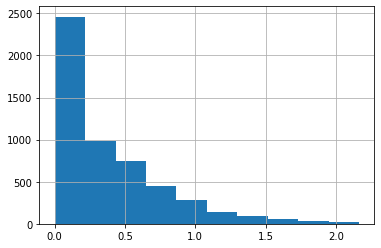

In [204]:
np.log10(in_degree).hist()

infomap get clusters, distance between them etc

In [123]:
from infomap import Infomap

def df_to_infomap_net(node_interactions):
    # Command line flags can be added as a string to Infomap
    im = Infomap("--two-level --directed")
    for from_idx, to_idx in node_interactions.iteritems():
        # Add weight as optional third argument
        im.add_link(from_idx, to_idx)
    return im

im = df_to_infomap_net(node_interactions)

In [109]:
im.run()

In [121]:
im.num_top_modules

2576

In [120]:
np.unique([x for x in im.get_modules(depth_level=3).values()])

array([1])

# Weigh user interactions by cell

In [234]:
user_interactions = interactions.get_cell_ratio(raw_user_interactions, 
                                                user_cell_ratio)
user_interactions.head()

cld_lang  \
to_uid                                             uid                                                cell_id to_cell_id            
0000230a521501076e405dc5db67ddcde7984efff63ed66... 3c310206eb0c3f170af58fc8449e26d09d489dc8ffd2a6f... 416     442              es   
                                                                                                      417     442              es   
                                                                                                      389     442              es   
00020b17efebb69b78cc60ece3877c33176e159278922bf... 0b252d87679471513644d832df2bd232fbe3143d2e66c9c... 414     442              es   
                                                                                                      441     442              es   

                                                                                                                          count  \
to_uid                                             uid                                                cell_id to_cell_id          
0000230a521501076e405dc5db67ddcde7984efff63ed66... 3c310206eb0c3f170af58fc8449e26d09d489dc8ffd2a6f... 416     442           1.0   
                                                                                                      417     442           1.0   
                                                                                                      389     442           1.0   
00020b17efebb69b78cc60ece3877c33176e159278922bf... 0b252d87679471513644d832df2bd232fbe3143d2e66c9c... 414     442           2.0   
                                                                                                      441     442           2.0   

                                                                                                                             ratio  \
to_uid                                             uid                                                cell_id to_cell_id             
0000230a521501076e405dc5db67ddcde7984efff63ed66... 3c310206eb0c3f170af58fc8449e26d09d489dc8ffd2a6f... 416     442         0.676882   
                                                                                                      417     442         0.007481   
                                                                                                      389     442         0.315637   
00020b17efebb69b78cc60ece3877c33176e159278922bf... 0b252d87679471513644d832df2bd232fbe3143d2e66c9c... 414     442         0.102187   
                                                                                                      441     442         0.083159   

                                                                                                                          to_ratio  \
to_uid                                             uid                                                cell_id to_cell_id             
0000230a521501076e405dc5db67ddcde7984efff63ed66... 3c310206eb0c3f170af58fc8449e26d09d489dc8ffd2a6f... 416     442              1.0   
                                                                                                      417     442              1.0   
                                                                                                      389     442              1.0   
00020b17efebb69b78cc60ece3877c33176e159278922bf... 0b252d87679471513644d832df2bd232fbe3143d2e66c9c... 414     442              1.0   
                                                                                                      441     442              1.0   

                                                                                                                          whole_ratio  
to_uid                                             uid                                                cell_id to_cell_id               
0000230a521501076e405dc5db67ddcde7984efff63ed66... 3c310206eb0c3f170af58fc8449e26d09d489dc8ffd2a6f... 416     442        

In [12]:
n_cells = cells_in_area_df.shape[0]
adjacency_dict = {lang: np.zeros((n_cells, n_cells)) 
                  for lang in area_dict['local_langs']}
cell_id_to_idx = {cell_id: idx for idx, cell_id in enumerate(cells_in_area_df.index)}
for lang, matrix in adjacency_dict.items():
    b = user_interactions.loc[user_interactions['cld_lang'] == lang].groupby(['cell_id', 'to_cell_id'])[['whole_ratio']].sum()
    for x in b.itertuples():
        i = cell_id_to_idx[x.Index[0]]
        j = cell_id_to_idx[x.Index[1]]
        matrix[i, j] += x.whole_ratio
        adjacency_dict[lang] = matrix

Number of users a user interact with

In [235]:
inc = user_interactions.reset_index().groupby('to_uid')['whole_ratio'].sum()
inc.index = inc.index.rename('uid')
out = user_interactions.reset_index().groupby('uid')['whole_ratio'].sum()
nr_to_from_interact = inc.add(out, fill_value=0)
nr_to_from_interact.describe()

count    58986.000000
mean        12.068355
std         52.283190
min          0.000000
25%          1.000000
50%          3.000000
75%          8.000000
max       4437.000000
Name: whole_ratio, dtype: float64

This gives half because we also count one way of interactions, so a pairiwse interaction only counts as one, thus it's not saying how many interactions people are involved in

In [236]:
nr_interacting_users = np.unique(
    user_interactions.reset_index()['uid'].unique().tolist() 
    + user_interactions.reset_index()['to_uid'].unique().tolist()).shape[0]
user_interactions['whole_ratio'].sum() / nr_interacting_users

6.034177601464762

# Plots

## Cell interactions by language

There are 153285.0 pairwise interactions in Spanish
self: 34996.309458583535
not self: 118288.69054139312
not self, above threshold: 101845.24177292908


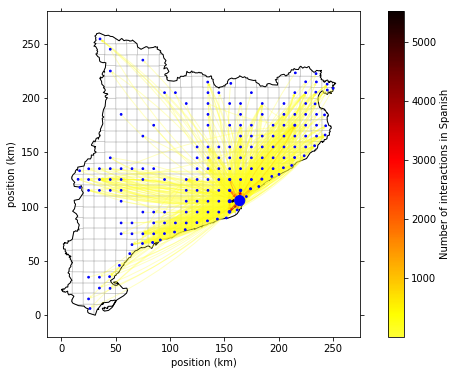

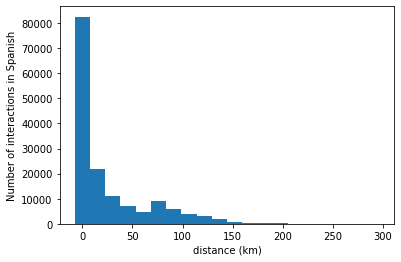

There are 202647.00000000006 pairwise interactions in Catalan
self: 38140.58812248028
not self: 164506.41187749754
not self, above threshold: 135753.07212354016


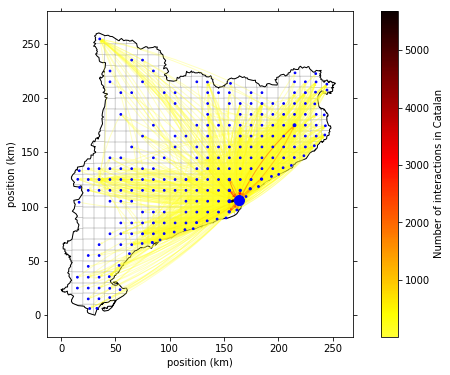

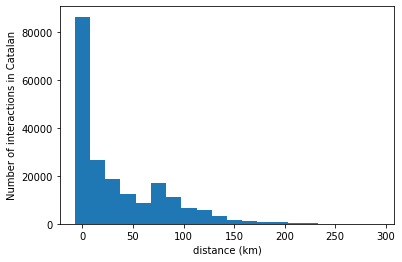

In [244]:
nr_bins = 20
cell_size = cells_in_area_df.cell_size
cell_centers = cells_in_area_df.geometry.centroid.rename('cell_center')
og_cmap = plt.get_cmap('hot').reversed()
edge_cmap = colors.LinearSegmentedColormap.from_list(
    'my_cmap', og_cmap(np.linspace(0.2, 1, 200)))
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
for lang, lang_dict in plot_langs_dict.items():
    grp_readable = lang_dict['readable']
    lang_mask = user_interactions['cld_lang'] == lang
    lang_interactions = user_interactions.loc[lang_mask].copy()
    nr_interactions = lang_interactions['whole_ratio'].sum()
    print(f'There are {nr_interactions} pairwise interactions in {grp_readable}')
    cell_interactions = lang_interactions.groupby(['cell_id', 'to_cell_id'])['whole_ratio'].sum().reset_index()
#     plot_title = f'{grp_readable} interactions in {area_name}'
    cbar_label = f'Number of interactions in {grp_readable}'
    save_path = os.path.join(
        fig_dir, cc, 'networks',
        f'interaction_network_{area_name}_lang={lang}_cell_size={cell_size}m.pdf')
    ax = net_viz.plot_cell_interactions(
        cell_interactions, cells_in_area_df, shape_df,
        edge_cmap=edge_cmap, edge_th=10, save_path=save_path,
        cbar_label=cbar_label)
    save_path = os.path.join(
        fig_dir, cc, 'networks',
        f'interaction_dist_distrib_{area_name}_lang={lang}_cell_size={cell_size}m.pdf')
    net_viz.edge_dist_distrib(cell_interactions, cell_centers, cbar_label,
                              save_path=save_path)

In [54]:
cell_interactions.sort_values(by='whole_ratio').tail()

,cell_id,to_cell_id,whole_ratio
454,509,486,6.000000
891,531,99,8.000000
1491,99,531,12.325799
1487,99,99,13.000000
896,531,531,17.217199


Number of outgoing interactions by cell

In [ ]:
cell_interactions.reset_index().groupby('cell_id')['whole_ratio'].sum().describe()

Number of pairwise interactions

In [85]:
cell_interactions.loc[cell_interactions > 20].reset_index().groupby(['cell_id', 'to_cell_id'])['whole_ratio'].sum().describe()

ValueError: Cannot index with multidimensional key

## Cell interactions of multilinguals

definition of multilingual? reads or writes in >1 language? problem with reads: people can @ someone famous talking in their own language, even though their recipient never uses that language

In [239]:
user_langs_written = user_interactions.reset_index().groupby('uid')['cld_lang'].nunique()
user_langs_read = user_interactions.reset_index().groupby('to_uid')['cld_lang'].nunique()
multiling_users = np.unique(user_langs_written.loc[user_langs_written > 1].index.tolist())
#                             + user_langs_read.loc[user_langs_read > 1].index.tolist())
nr_multiling_users = multiling_users.shape[0]
print(nr_multiling_users)
# interacting with how many users?

14029


There are 281297.99999999994 interactions to and from multilinguals
There are 281297.99999999587 interactions to and from multilinguals
self: 55198.909930222035
not self: 226099.0900697739
not self, above threshold: 205603.33200887684


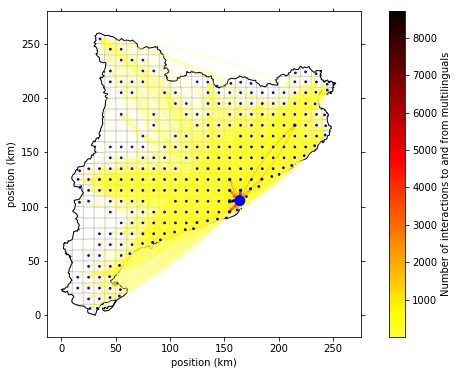

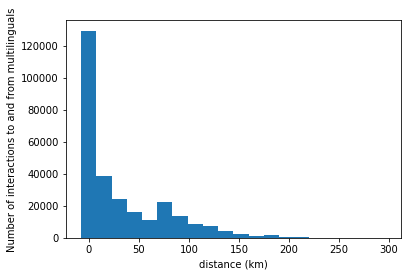

In [245]:
cell_size = cells_in_area_df.cell_size
og_cmap = plt.get_cmap('hot').reversed()
edge_cmap = colors.LinearSegmentedColormap.from_list(
    'my_cmap', og_cmap(np.linspace(0.2, 1, 200)))

multiling_interactions = user_interactions.reset_index()
multiling_mask = ((multiling_interactions['uid'].isin(multiling_users))
                  | (multiling_interactions['to_uid'].isin(multiling_users)))
# drop duplicates so that when a user sends messags in more than one language to
# another, it still counts as only one interaction
cell_cols = ['cell_id', 'to_cell_id']
user_cols = ['uid', 'to_uid']
multiling_interactions = (
    multiling_interactions.loc[multiling_mask]
                          .drop_duplicates(subset=user_cols+cell_cols))
nr_interactions = multiling_interactions['whole_ratio'].sum()
print(f'There are {nr_interactions} interactions to and from multilinguals')
cell_interactions = (
    multiling_interactions.groupby(cell_cols)['whole_ratio']
                          .sum()
                          .reset_index())
nr_interactions = cell_interactions['whole_ratio'].sum()
print(f'There are {nr_interactions} interactions to and from multilinguals')
# plot_title = f'Interactions involving multilinguals in {area_name}'
cbar_label = f'Number of interactions to and from multilinguals'
save_path = os.path.join(
    fig_dir, cc, 'networks',
    f'interaction_network_{area_name}_multiling_cell_size={cell_size}m.pdf')
ax = net_viz.plot_cell_interactions(
    cell_interactions, cells_in_area_df, shape_df,
    edge_cmap=edge_cmap, edge_th=10, save_path=save_path,
    cbar_label=cbar_label)
save_path = os.path.join(
    fig_dir, cc, 'networks',
    f'interaction_dist_distrib_{area_name}_multiling_cell_size={cell_size}m.pdf')
net_viz.edge_dist_distrib(cell_interactions, cell_centers, cbar_label,
                          save_path=save_path)

In [51]:
cell_interactions.sort_values(by='whole_ratio').tail()

,cell_id,to_cell_id,whole_ratio
1363,265.0,265.0,26.113383
3420,454.0,478.0,30.080456
590,185.0,454.0,33.353407
1403,265.0,454.0,37.921078
3414,454.0,454.0,70.674336


Here the average is done ove all users interacting with multilinguals, not only multilinguals

In [220]:
inc = multiling_interactions.groupby('to_uid')['whole_ratio'].sum()
inc.index = inc.index.rename('uid')
out = multiling_interactions.groupby('uid')['whole_ratio'].sum()
nr_to_from_interact = inc.add(out, fill_value=0)
nr_to_from_interact.describe()

count    3447.00000
mean        4.51349
std        18.92309
min         0.00000
25%         1.00000
50%         1.00000
75%         3.00000
max       539.00000
Name: whole_ratio, dtype: float64

As opposed to here, where it's over multilinguals only

In [221]:
inc = multiling_interactions.loc[multiling_interactions['to_uid'].isin(multiling_users)].groupby('to_uid')['whole_ratio'].sum()
inc.index = inc.index.rename('uid')
out = multiling_interactions.loc[multiling_interactions['uid'].isin(multiling_users)].groupby('uid')['whole_ratio'].sum()
nr_to_from_multi_interact = inc.add(out, fill_value=0)
nr_to_from_multi_interact.describe()

count    302.000000
mean      27.672185
std       58.258747
min        1.000000
25%        4.000000
50%       10.000000
75%       26.000000
max      539.000000
Name: whole_ratio, dtype: float64

In [222]:
print(f'Number of interactions in which a multilingual is involved on average: {nr_interactions / multiling_users.shape[0]}')

Number of interactions in which a multilingual is involved on average: 25.758278145695368


In [223]:
cell_interactions.reset_index().groupby('cell_id')['whole_ratio'].sum().describe()

count    280.000000
mean      27.782143
std       73.168824
min        0.000019
25%        1.000000
50%        4.696365
75%       21.048734
max      752.683840
Name: whole_ratio, dtype: float64

In [224]:
(nr_interacting_users / nr_multiling_users 
 * user_interactions['whole_ratio'].sum() / multiling_interactions['whole_ratio'].sum()
 * nr_to_from_interact.mean() / nr_to_from_multi_interact.mean())

74.58784425599443

In [225]:
nr_to_from_interact.mean()

4.51348999129678

do as in Hale 2014?

rate of language change to get an idea of real time scale, (ref is the voter model a model for voters?, fig3)